###https://www.sciencedirect.com/science/article/pii/S1568494624002655

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 載入資料
# df = pd.read_csv("female_stroke_data.csv")  # 檔案路徑
df = pd.read_csv("../male_data.csv")  # 檔案路徑

# 分離 features & labels
X = df.drop(columns=["Second_Stroke"])
y = df["Second_Stroke"]

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 標準化（對 DCNN 來說很重要）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("y_train class distribution:", np.bincount(y_train))
print("y_test class distribution:", np.bincount(y_test))
print("Data preprocessing done!")

y_train class distribution: [695  37]
y_test class distribution: [175   9]
Data preprocessing done!


In [13]:
X.columns

Index(['age', 'sex', 'HLOS', 'NIHSS', 'tPA(0/1)', 'EVT(0/1)', 'HTN(0/1)',
       'DM(0/1)', 'Dyslipidemia(0/1)', 'Af(0/1)', 'smoking(Y/N/Q)', 'LDL ',
       'cholesterol', 'TG', 'Cre', 'SGPT', 'HbA1c', 'MRS'],
      dtype='object')

In [14]:
# !pip3 install geneticalgorithm

 The best solution found:                                                                           
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]

 Objective function:
 -0.9521857923497268


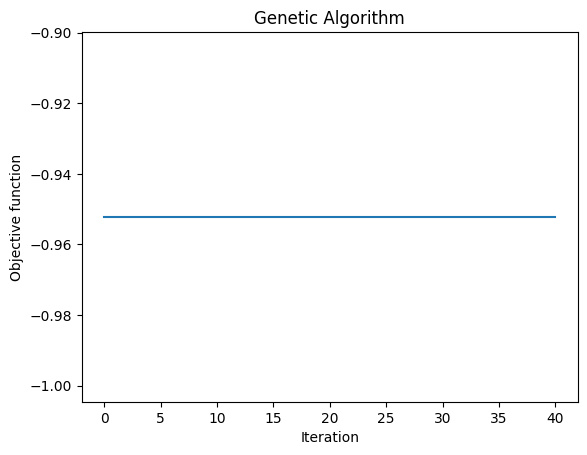

X_train shape:  (732, 18)
X_test shape:  (184, 18)
X_train_selected shape:  (732, 9)
X_test_selected shape:  (184, 9)
Selected important features:
Index(['age', 'tPA(0/1)', 'EVT(0/1)', 'DM(0/1)', 'Dyslipidemia(0/1)',
       'smoking(Y/N/Q)', 'LDL ', 'cholesterol', 'TG'],
      dtype='object')
Feature selection done!


In [15]:
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 適應度函數（用 RF 來評估特徵組合）
def fitness_function(selected_features):
    selected_features = selected_features.astype(bool)
    # ➤ 若完全沒選到特徵，回傳高錯誤值
    if np.sum(selected_features) == 0:
        return 1.0  # 因為是要最小化，這代表很差的分數
    
    X_selected = X_train[:, selected_features]

    model = RandomForestClassifier()
    scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')

    return -scores.mean()  # GA 會最小化這個值，所以取負值


from sklearn.feature_selection import VarianceThreshold

# 設定方差閾值（0表示完全相同的特徵將會被刪除）
selector = VarianceThreshold(threshold=0)
X_train_filtered = selector.fit_transform(X_train)
X_test_filtered = selector.transform(X_test)

# 設定 GA 參數
var_bound = np.array([[0, 1]] * X_train.shape[1])  # 每個特徵 0 or 1
algorithm_param = {
    'max_num_iteration': 40,
    'population_size': 100,
    'mutation_probability': 0.4,
    'crossover_probability': 0.7,
    'crossover_type': 'one_point',
    'elit_ratio': 0.01,  # 留著不影響結果
    'parents_portion': 0.3,  # 可保留
    'max_iteration_without_improv': None,
    # 👉 圖中這項沒在原套件參數，但你可在 GA 實作時控制 mutation 行為
    # 'mutation_by_bit': 0.1 (假如用自訂 GA 可控制)
}

# 進行 GA
model = ga(function=fitness_function, 
           dimension=X_train.shape[1], 
           variable_type='int', 
           variable_boundaries=var_bound, 
           algorithm_parameters=algorithm_param)

model.run()

# 取得最佳特徵組合
best_features = model.output_dict['variable'].astype(bool)

X_train_selected = X_train[:, best_features]
X_test_selected = X_test[:, best_features]


# 取得對應欄位名稱
best_features = np.array(best_features).astype(bool)
selected_columns = X.columns[best_features]

# 印出
print("Selected important features:")
print(selected_columns)
print("X_train_selected shape: ", X_train_selected.shape)
print("X_test_selected shape: ", X_test_selected.shape)
print("Feature selection done!")

In [16]:
from imblearn.over_sampling import SMOTE

# 使用 SMOTE 做 data augmentation
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("Data augmentation done! New class distribution:", np.bincount(y_train_balanced))

Data augmentation done! New class distribution: [695 695]


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models  # ✅ 加上這行

# 資料 reshape 成 CNN 格式
X_train_balanced_reshaped = X_train_balanced.reshape(-1, X_train_balanced.shape[1], 1)

# 建立 DCNN 模型
model = models.Sequential()
model.add(layers.Input(shape=(X_train_balanced.shape[1], 1)))

for _ in range(10):
    model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='sigmoid'))  # 改用 relu 試試
model.add(layers.Dense(1, activation='sigmoid'))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# # 開始訓練
# history = model.fit(
#     X_train_balanced_reshaped,
#     y_train_balanced ,
#     epochs=400,
#     batch_size=30,
#     validation_split=0.2,
#     verbose=1
# )

from tensorflow.keras.utils import Sequence
import numpy as np

from tensorflow.keras.utils import Sequence
import numpy as np

class BalancedBatch(Sequence):
    def __init__(self, X, y, batch_size=10):
        self.X = X
        self.y = y.reset_index(drop=True)  # 確保 index 是連續的
        self.batch_size = batch_size
        self.pos_indices = self.y[self.y == 1].index.to_numpy()
        self.neg_indices = self.y[self.y == 0].index.to_numpy()
        self.num_batches = min(len(self.pos_indices), len(self.neg_indices)) * 2 // batch_size
        np.random.shuffle(self.pos_indices)
        np.random.shuffle(self.neg_indices)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        half = self.batch_size // 2
        start = idx * half
        end = start + half

        pos_idx = self.pos_indices[start:end]
        neg_idx = self.neg_indices[start:end]

        # 混合正負樣本
        batch_indices = np.concatenate([pos_idx, neg_idx])
        np.random.shuffle(batch_indices)

        X_batch = self.X[batch_indices]
        y_batch = self.y.iloc[batch_indices].to_numpy().reshape(-1, 1)

        # print("✅ Batch y 分布:", np.bincount(y_batch.flatten()))
        return X_batch, y_batch


gen = BalancedBatch(X_train_balanced_reshaped, y_train_balanced, batch_size=10)

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_balanced_reshaped, y_train_balanced, 
    test_size=0.2, stratify=y_train_balanced, random_state=42)

# 模型改用 gen 作為資料輸入
history = model.fit(
    gen,
    epochs=400,
    validation_data=(X_val, y_val.to_numpy().reshape(-1, 1)),  # 這裡補上 validation 資料
    verbose=1
)

print("Model training done!")

Epoch 1/400
139/139 [==============================] - 8s 13ms/step - loss: 0.7150 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.5180
Epoch 2/400
139/139 [==============================] - 1s 10ms/step - loss: 0.7153 - accuracy: 0.4871 - val_loss: 0.6945 - val_accuracy: 0.4676
Epoch 3/400
139/139 [==============================] - 1s 10ms/step - loss: 0.7072 - accuracy: 0.5122 - val_loss: 0.6955 - val_accuracy: 0.5324
Epoch 4/400
139/139 [==============================] - 1s 10ms/step - loss: 0.7032 - accuracy: 0.5187 - val_loss: 0.6960 - val_accuracy: 0.5216
Epoch 5/400
139/139 [==============================] - 2s 13ms/step - loss: 0.6966 - accuracy: 0.5432 - val_loss: 0.6949 - val_accuracy: 0.5216
Epoch 6/400
139/139 [==============================] - 2s 11ms/step - loss: 0.6974 - accuracy: 0.5173 - val_loss: 0.6968 - val_accuracy: 0.5180
Epoch 7/400
139/139 [==============================] - 2s 11ms/step - loss: 0.6928 - accuracy: 0.5223 - val_loss: 0.6880 - val_accuracy:

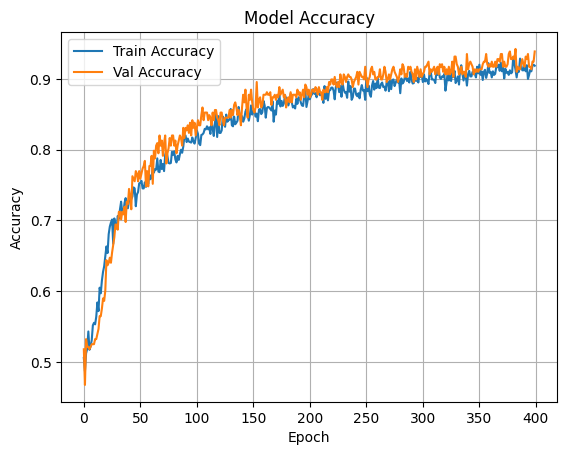

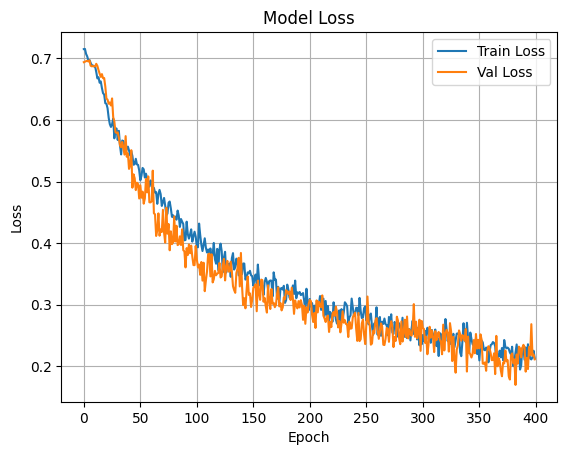

In [20]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# 預測
y_pred = (model.predict(X_test_selected) > 0.5).astype(int)

# 評估結果
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print("Model evaluation done!")

6/6 [==============================] - 0s 3ms/step
Confusion Matrix:
 [[143  32]
 [  5   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89       175
           1       0.11      0.44      0.18         9

    accuracy                           0.80       184
   macro avg       0.54      0.63      0.53       184
weighted avg       0.92      0.80      0.85       184

Model evaluation done!
